In [ ]:
# Flowers

# Download the Dataset

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [5]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [6]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ehtisham49
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:02<00:00, 94.3MB/s]


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = './flowers-recognition/flowers'

In [9]:
import os


In [10]:
os.listdir(data_dir)

['rose', 'tulip', 'dandelion', 'sunflower', 'daisy']

In [11]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

rose : 784
tulip : 984
dandelion : 1052
sunflower : 733
daisy : 764


In [12]:
os.listdir(data_dir)

['rose', 'tulip', 'dandelion', 'sunflower', 'daisy']

# Import the Dataset Into PyTorch

In [13]:
from torchvision.datasets import ImageFolder

In [14]:
dataset = ImageFolder(data_dir)

In [15]:
len(dataset)

4317

In [16]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FA199013990>, 0)

In [17]:
dataset.classes


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

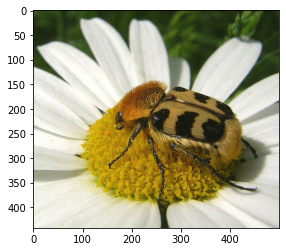

In [19]:
img, label = dataset[120]
plt.imshow(img)

In [20]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

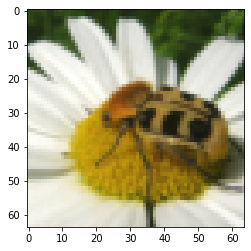

In [21]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [22]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [23]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [24]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


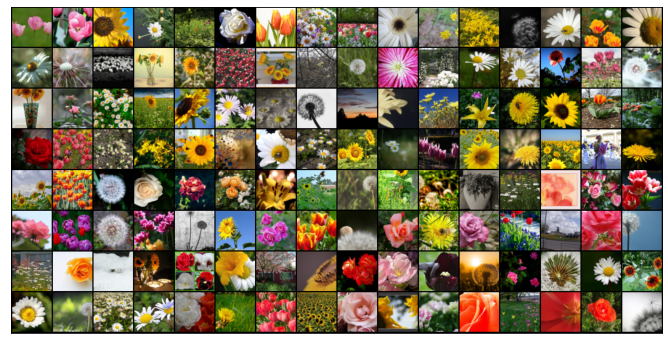

In [26]:
show_batch(train_dl)

# GPU Utilities

In [27]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
torch.cuda.is_available()

False

In [29]:
device = get_default_device()

In [30]:
device

device(type='cpu')

In [31]:
img, label = dataset[0]

In [32]:
img.device

device(type='cpu')

In [33]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#  Model and Training Utilties

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#  Model

In [38]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [39]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [40]:
model.conv1[0].weight.device

device(type='cpu')

In [41]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cpu
preds.shape torch.Size([128, 5])


# Training

In [42]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.16277426481246948, 'val_loss': 1.6126936674118042}]

In [43]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.5051, val_loss: 1.3366, val_acc: 0.4051
Epoch [1], train_loss: 1.0152, val_loss: 0.9553, val_acc: 0.6395
Epoch [2], train_loss: 0.8875, val_loss: 0.8349, val_acc: 0.6718
Epoch [3], train_loss: 0.8245, val_loss: 0.8330, val_acc: 0.6912
Epoch [4], train_loss: 0.7564, val_loss: 0.9502, val_acc: 0.6546


In [44]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.8628, val_loss: 0.9626, val_acc: 0.6825
Epoch [1], train_loss: 0.7077, val_loss: 0.8740, val_acc: 0.6786
Epoch [2], train_loss: 0.6040, val_loss: 0.8257, val_acc: 0.6972
Epoch [3], train_loss: 0.5622, val_loss: 1.0646, val_acc: 0.6688
Epoch [4], train_loss: 0.5149, val_loss: 0.6743, val_acc: 0.7526


In [45]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4006, val_loss: 0.5591, val_acc: 0.7854
Epoch [1], train_loss: 0.3592, val_loss: 0.5475, val_acc: 0.7975
Epoch [2], train_loss: 0.3288, val_loss: 0.5167, val_acc: 0.8081
Epoch [3], train_loss: 0.3183, val_loss: 0.5537, val_acc: 0.7936
Epoch [4], train_loss: 0.2990, val_loss: 0.5568, val_acc: 0.8073


In [47]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

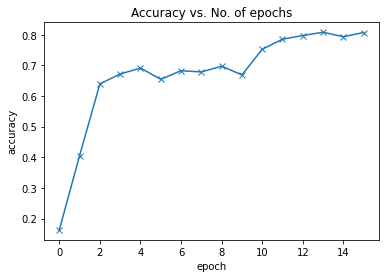

In [48]:
plot_accuracies(history)

In [49]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

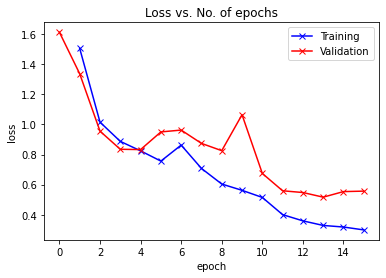

In [50]:
plot_losses(history)

# Record the Results

In [ ]:
history[-1]

# Test with Individual Images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

In [ ]:
show_image_prediction(*valid_ds[100])

In [ ]:
show_image_prediction(*valid_ds[300])

In [ ]:
show_image_prediction(*valid_ds[12])